In [2]:
from imports import *
np.seterr(all='ignore')
from scipy.stats import bartlett
from scipy.stats import shapiro
from scipy.stats import levene

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import glm
from statsmodels.formula.api import gls
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [3]:
import scikit_posthocs as sp

In [4]:
def multi_mannwhitneyu(values,n = None):
    """
    This function compute pairwise manvhitneyu and correct with the bonferoni correction
    """

    if n is None:
        n = len(values)
    stats = []

    for i in itertools.combinations(values.keys(),2):
        f,pvalue = scipy.stats.mannwhitneyu(values[i[0]],values[i[1]])
        stat = {'Name':['-'.join(i)],
                'Statistic':f,
                'pValue':pvalue,
                'p-Ajusted':pvalue*n}
        stats.append(pd.DataFrame(stat))
    return pd.concat(stats)

def multi_wilcoxon(values,n = None):
    """
    This function compute pairwise wilcoxon and correct with the bonferoni correction
    """

    if n is None:
        n = len(values)

    stats = []
    for i in itertools.combinations(values.keys(),2):
        f,pvalue = scipy.stats.wilcoxon(values[i[0]],values[i[1]])
        stat = {'Name':['-'.join(i)],
                'Statistic':f,
                'pValue':pvalue,
                'p-Ajusted':pvalue*n}
        stats.append(pd.DataFrame(stat))
    return pd.concat(stats)

In [5]:
from statannotations.Annotator import Annotator

In [6]:
def discard_border(state, t):
    state.start = state.start + (t * 1_000_000)
    state.end = state.end - (t * 1_000_000)

def compute_sync(neurons, metadata, stru, types, start=0, stop=None, binSize=0.025, nbins=None ): 
    """
    This function compute sync value between two time point for a structure of interest
    """
    # Check what type of neurons we are working with and bin the spikes only of those.
    if types == 'Pyr' : activity = bk.compute.binSpikes(neurons[(metadata.Region == stru)& (metadata.Type == 'Pyr')], start=start, stop=stop,binSize = binSize, as_Tsd=True)
    if types == 'Int' : activity = bk.compute.binSpikes(neurons[(metadata.Region == stru)& (metadata.Type == 'Int')], start=start, stop=stop,binSize = binSize, as_Tsd=True)
    if types == 'both' : activity = bk.compute.binSpikes(neurons[(metadata.Region == stru)], start=start, stop=stop,binSize = binSize, as_Tsd=True)
    
    # Compute the corr matrix and then compute the synchrony as the average of the pairwise correlation matrix of the binspikes matrices
    corr = np.corrcoef(activity,rowvar=False)
    np.fill_diagonal(corr,np.nan)
    sync = np.nanmean(corr)
    return sync

def sync_intervals(neurons,metadata,stru,types,intervals,binSize):
    """
    This function computes synchrony values for a given list of intervals.
    
    Arguments:
    neurons -- List of neurons (Ts)
    metadata -- DataFrame containing information on the neurons
    stru -- The structures of interest ('BLA','Hpc')
    types -- Types of neuron to be considered ('Pyr','Int','Both')
    intervals -- nts.IntervalSet
    binSize -- Size of the bin used for the computation of the corrmatrix
    """
    if len(intervals) == 0:
        sync = np.nan
        return sync
    
    #iterate over all epochs of one state
    intervals_sync_matrix = []
    for s,e in tqdm(intervals.as_units('s').iloc(),total = len(intervals)):
        # inter = nts.IntervalSet(s,e,time_units='s')
        #Compute one value of sync by epochs and add it to a list. 
        sync_ = compute_sync(neurons,metadata,start = s,stop = e,binSize = binSize,stru = stru,types = types)
        intervals_sync_matrix.append(sync_)
    return intervals_sync_matrix


def norm(df):
    df = df.copy()
    df['Middle'] = df['Middle']/df['First'] * 100
    df['Last'] = df['Last']/df['First'] * 100
    df['First'] = df['First']/df['First'] * 100
    return df

In [313]:
def main(base_folder, local_path, *args, **kwargs):
    """
    This function computes synchrony values for states REM/NREM/WAKE_HOMECAGE
    
    Arguments:
    base_folder -- Folder with the data
    local_path -- Local path to the session to be treated

    **kwargs -- A dict of other parameters, namely : 
        - stru: The structures of interest ('BLA','Hpc')
        - types: Types of neuron to be considered ('Pyr','Int','Both')
        - binSize: The size of the binning matrix
        - minimal_duration_epoch: The minimal length of a epoch to be considered in this analyis. Other epoch are discared
        - min_neurons: Minimal number of pyramidal neurons to be considered 
        - time_from_border: Can remove edges of each epochs in case of blurry transitions. 
    ...
    
    Returns:
    df -- A DataFrame with a line by epoch. It contains the average synchrony of this epoch and the state of the epoch
    ...
    """

    stru = kwargs['stru']
    types = kwargs['types']
    binSize = kwargs['binSize']
    min_duration_epoch = kwargs['min_duration']
    min_neurons = kwargs['min_neurons']
    time_from_border = kwargs['time_from_border']

    #Load session
    bk.load.current_session_linux(base_folder=base_folder, local_path=local_path)
    neurons, metadata = bk.load.spikes()
    states = bk.load.states(True)

    # Remove wake and drowsy intervals as they are not intereting here 
    for s in ['wake', 'drowsy']:
        states.pop(s)

    # if not enough neurons raise an exception
    if len(neurons[(metadata.Region == stru)& (metadata.Type == 'Pyr')])<min_neurons:
        raise Exception('Not Enough Neurons')

    sync = {}
    df = pd.DataFrame()
    # For each state left in states.items compute a value of sync per epoch
    for k, state in states.items():
        # We remove what is close to transition as the sleep scoring might not be perfect
        discard_border(state, time_from_border[k])
        state = state.drop_short_intervals(min_duration_epoch[k], 's').reset_index(drop=True)
        sync[k] = sync_intervals(neurons, metadata, stru, types, state, binSize)
        df_ = pd.DataFrame(sync[k],columns=['Sync'])
        df_['State'] = k
        df = pd.concat((df,df_))
    df['Rat'] = bk.load.rat
    df['Day'] = bk.load.day
    return df


kwargs = {'stru': 'BLA',
          'types': 'Pyr',
          'binSize': 0.1,
          'min_duration':
          {
              'REM': 30,
              'NREM': 200,
              'WAKE_HOMECAGE': 200
          },
          'min_neurons':11,
          'time_from_border':
          {'REM': 0,
           'NREM': 0,
           'WAKE_HOMECAGE':0
           }
          }
bk.load.current_session_linux()
# main(bk.load.base,'Rat08/Rat08-20130713',**kwargs)
batch, metadata = bk.load.batch(main, **kwargs)

100%|██████████| 61/61 [02:00<00:00,  1.97s/it]

Batch finished in 120.10240578651428
Some session were not processed correctly
['Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140704', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
45.90163934426229 %


<AxesSubplot: xlabel='Rat', ylabel='Sync'>

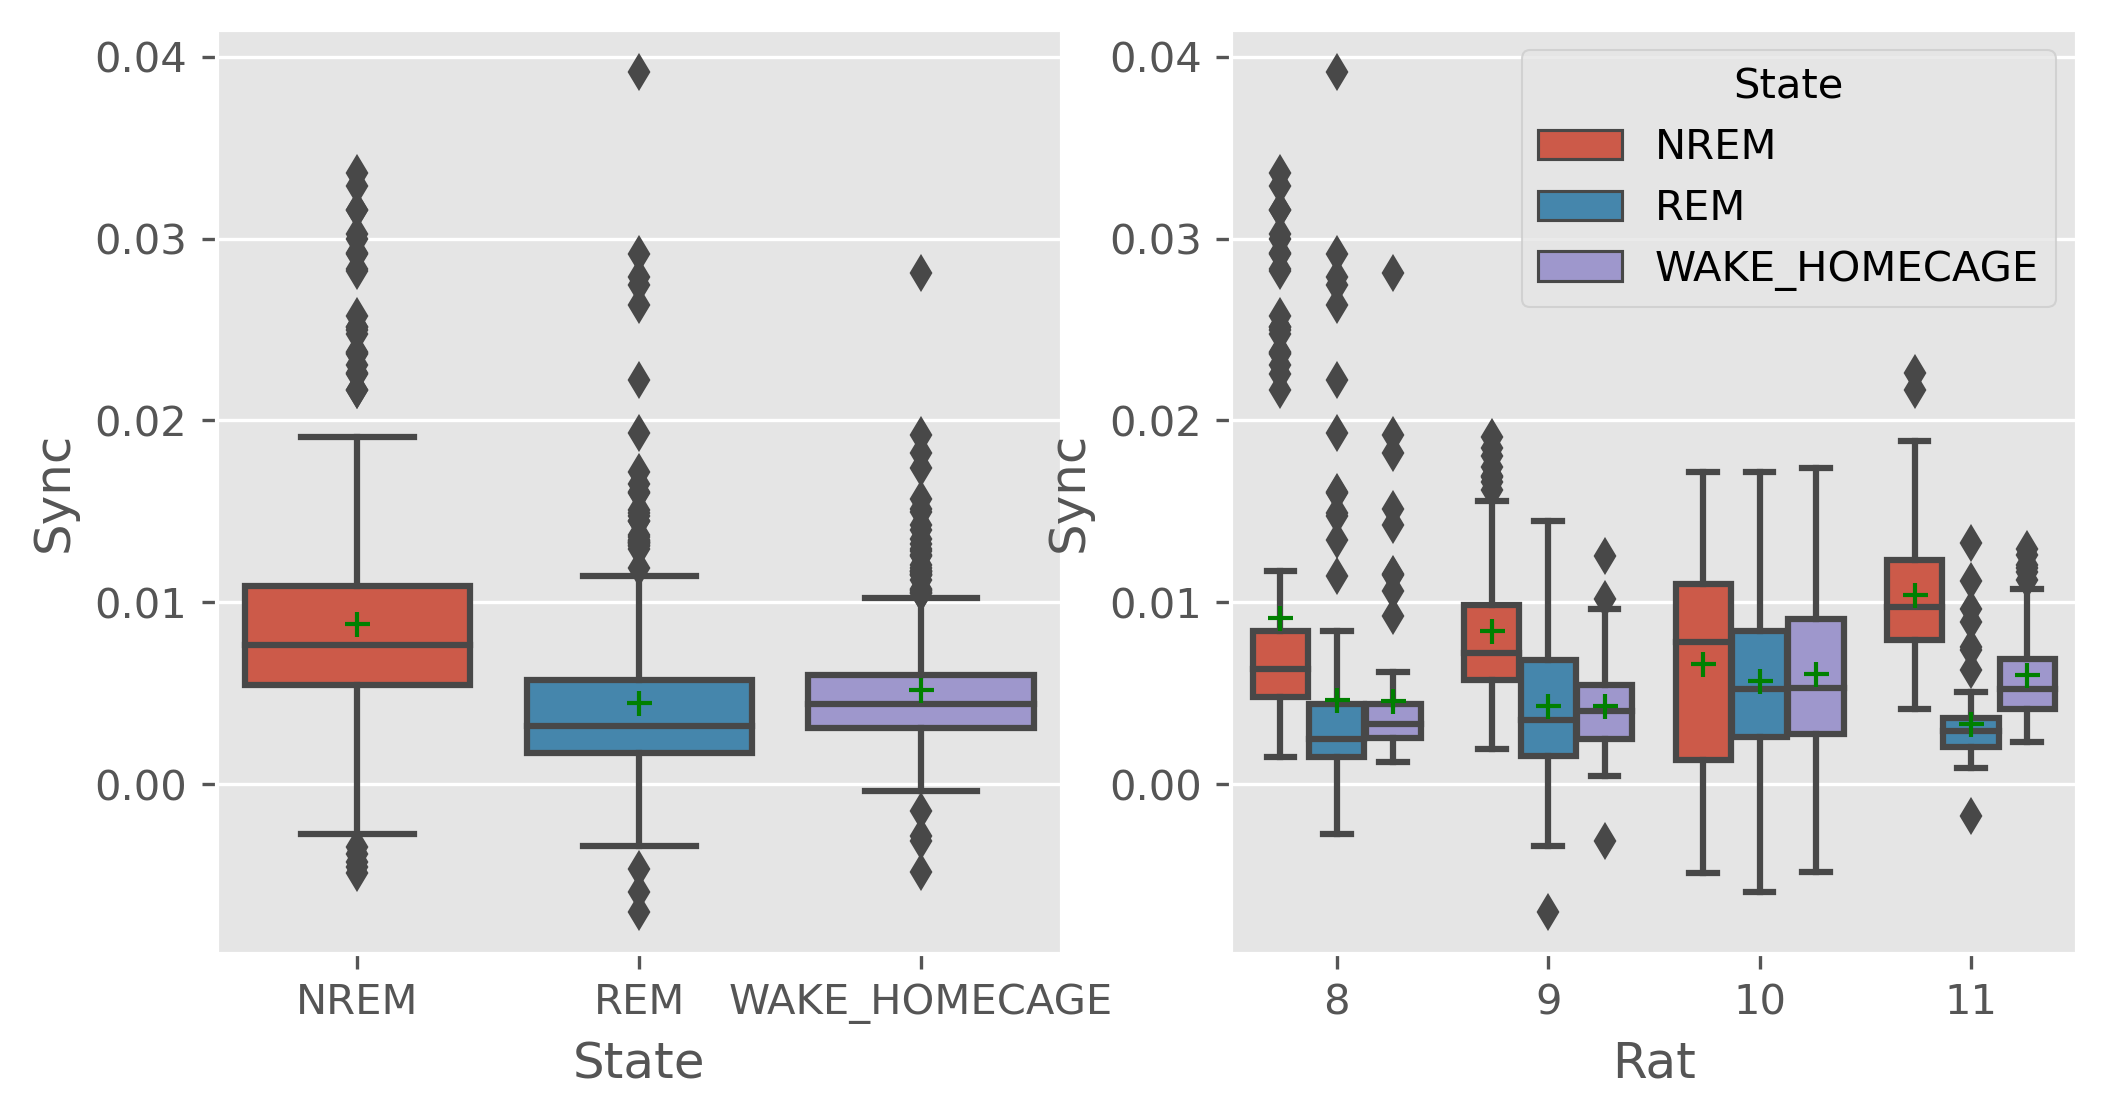

In [317]:
all_sync = pd.concat(batch)

fig,ax = plt.subplots(1,2,dpi = 300,figsize = (8,4))
sns.boxplot(data=all_sync,x='State',y='Sync',showmeans = True,meanprops = {'marker':'+',"markeredgecolor":'green'},ax = ax[0],order = ['NREM','REM','WAKE_HOMECAGE'])
sns.boxplot(data=all_sync,x='Rat',y='Sync',hue = 'State',showmeans = True,meanprops = {'marker':'+',"markeredgecolor":'green'},ax = ax[1],hue_order = ['NREM','REM','WAKE_HOMECAGE'])


In [7]:
all_sync = pd.read_csv('/mnt/electrophy/Gabrielle/GG-Dataset-Light/All-Rats/Synchrony/sync_states.csv')
m_comp = pairwise_tukeyhsd(all_sync['Sync'], all_sync['State'], alpha=0.05)
m_comp.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
NREM,REM,-0.0043,0.0,-0.0052,-0.0035,True
NREM,WAKE_HOMECAGE,-0.0036,0.0,-0.0045,-0.0027,True
REM,WAKE_HOMECAGE,0.0007,0.1739,-0.0002,0.0017,False


In [11]:
len(np.unique(all_sync['Unnamed: 0']))

33

In [39]:
scipy.stats.kruskal(all_sync['Sync'][all_sync.State == 'NREM'],
                    all_sync['Sync'][all_sync.State == 'REM'],
                    all_sync['Sync'][all_sync.State == 'WAKE_HOMECAGE'])

KruskalResult(statistic=237.36253470800375, pvalue=2.866688359093911e-52)

In [40]:
sp.posthoc_dunn(all_sync,group_col='State',val_col='Sync',p_adjust='bonferroni')

,NREM,REM,WAKE_HOMECAGE
NREM,1.000000e+00,5.062467e-49,3.210356e-24
REM,5.062467e-49,1.000000e+00,3.557173e-04
WAKE_HOMECAGE,3.210356e-24,3.557173e-04,1.000000e+00


In [41]:
pairs = list(itertools.combinations(m_comp.groupsunique,2))
pvalues = m_comp.pvalues
formatted_pvalues = bk.stats.formatting_pvalues(pvalues)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NREM vs. REM: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.134e-41 U_stat=1.139e+05
REM vs. WAKE_HOMECAGE: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.285e-07 U_stat=3.899e+04
NREM vs. WAKE_HOMECAGE: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.348e-30 U_stat=9.668e+04


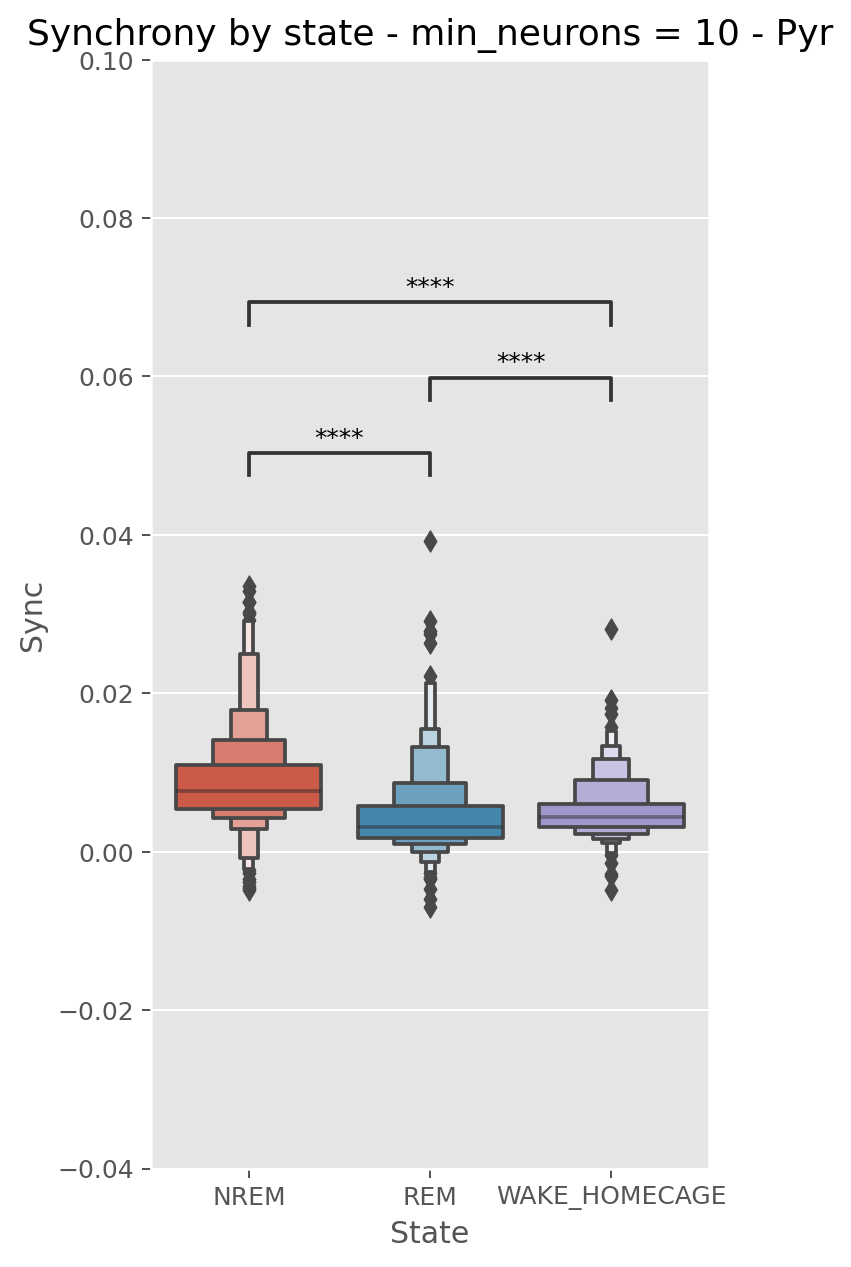

In [45]:
# np.save('/mnt/electrophy/Gabrielle/GG-Dataset-Light/All-Rats/Synchrony/sync_states.npy',all_sync,allow_pickle=True)
fig,ax = plt.subplots(figsize=(4,8),dpi = 180)
plotting_params = {'data': all_sync,
                   'y': 'Sync',
                   'x':'State',
                   'order':['NREM','REM','WAKE_HOMECAGE'],
                   'ax':ax}
sns.boxenplot(**plotting_params)
plt.title(f'Synchrony by state - min_neurons = 10 - Pyr')
plt.ylim(-0.04,0.1)

annotator = Annotator(pairs = pairs,**plotting_params)
annotator.configure(test="Mann-Whitney",comparisons_correction = 'Bonferroni').apply_and_annotate()
plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures/Ongoing/synchrony/Parts/sync_states.svg')

In [335]:
def anova(df, formula):
    print(df)
    lm = ols(formula, df).fit()
    anova_table = anova_lm(lm)
    print(anova_table)

    levene(df.Sync[df.State == 'NREM'],
           df.Sync[df.State == 'REM'],
           df.Sync[df.State == 'WAKE_HOMECAGE'])
    
    fig, ax = plt.subplot_mosaic('''
                                AAABBB
                                FFFGGG
                                CCDDEE''', dpi=180, figsize=(12, 12))
    sns.stripplot(data=df, x='State', y='Sync', ax=ax['A'],alpha = 0.65,s = 3)
    ax['A'].set_title('BOX PLOT EIB')
    ax['A'].set_ylim(-0.04,0.1)
    sm.qqplot(lm.resid, fit=True, line='45', ax=ax['B'])
    ax['B'].set_title('QQPlot Residuals')

    sns.boxenplot(data=df, x='Rat', y='Sync', ax=ax['F'])
    sns.boxenplot(data=df, x='Day', y='Sync', ax=ax['G'])

    for ax_, data in zip(['C', 'D', 'E'], np.unique(df.State)):
        sm.qqplot(df.Sync[df.State == data], ax=ax[ax_], fit=True, line='45')
        ax[ax_].set_title(f'QQPlot {data}')
    plt.tight_layout()

    m_comp = pairwise_tukeyhsd(df['Sync'], df['State'], alpha=0.05)
    print(m_comp.summary())
    print(m_comp.pvalues)



In [283]:
values_states = {}
for state in np.unique(all_sync.State): values_states[state] = all_sync[all_sync.State == state]['Sync'].values
print(scipy.stats.kruskal(values_states['NREM'],values_states['REM'],values_states['WAKE_HOMECAGE']))
multi_mannwhitneyu(values_states)

KruskalResult(statistic=237.36253470800375, pvalue=2.866688359093911e-52)


,Name,Statistic,pValue,p-Ajusted
0,NREM-REM,113868.0,3.779099e-42,1.133730e-41
0,NREM-WAKE_HOMECAGE,96679.0,7.827445e-31,2.348234e-30
0,REM-WAKE_HOMECAGE,38992.0,7.618319e-08,2.285496e-07


# Same but know we are going to compute the sync by third of epochs : 

In [25]:
def sync_intervals_third(neurons,metadata,stru,types,intervals,binSize):
    """
    This function computes synchrony values for a given list of intervals third by third.
    
    Arguments:
    neurons -- List of neurons (Ts)
    metadata -- DataFrame containing information on the neurons
    stru -- The structures of interest ('BLA','Hpc')
    types -- Types of neuron to be considered ('Pyr','Int','Both')
    intervals -- nts.IntervalSet
    binSize -- Size of the bin used for the computation of the corrmatrix
    """
    if len(intervals) == 0:
        sync = np.nan
        return sync
    
    #iterate over all epochs of one state
    intervals_sync_matrix = []
    for s,e in tqdm(intervals.as_units('s').iloc(),total = len(intervals)):
        # inter = nts.IntervalSet(s,e,time_units='s')
        #Compute one value of sync by epochs and add it to a list. 
        third_bins = np.linspace(s,e,4)
        sync_ = []
        for s_,e_ in zip(third_bins,np.roll(third_bins,-1)):
            if s_>e_: continue
            sync_third = compute_sync(neurons,metadata,start = s_,stop = e_,binSize = binSize,stru = stru,types = types)
            sync_.append(sync_third)
        intervals_sync_matrix.append(sync_)
    return intervals_sync_matrix
    

In [26]:
def main(base_folder, local_path, *args, **kwargs):
    """
    This function computes synchrony values for states REM/NREM/WAKE_HOMECAGE
    
    Arguments:
    base_folder -- Folder with the data
    local_path -- Local path to the session to be treated

    **kwargs -- A dict of other parameters, namely : 
        - stru: The structures of interest ('BLA','Hpc')
        - types: Types of neuron to be considered ('Pyr','Int','Both')
        - binSize: The size of the binning matrix
        - minimal_duration_epoch: The minimal length of a epoch to be considered in this analyis. Other epoch are discared
        - min_neurons: Minimal number of pyramidal neurons to be considered 
        - time_from_border: Can remove edges of each epochs in case of blurry transitions. 
    ...
    
    Returns:
    df -- A DataFrame with a line by epoch. It contains the average synchrony of this epoch third by third and the state of the epoch
    ...
    """

    stru = kwargs['stru']
    types = kwargs['types']
    binSize = kwargs['binSize']
    min_duration_epoch = kwargs['min_duration']
    min_neurons = kwargs['min_neurons']
    time_from_border = kwargs['time_from_border']

    #Load session
    bk.load.current_session_linux(base_folder=base_folder, local_path=local_path)
    neurons, metadata = bk.load.spikes()
    states = bk.load.states(True)

    # Remove wake and drowsy intervals as they are not intereting here 
    for s in ['wake', 'drowsy']:
        states.pop(s)

    # if not enough neurons raise an exception
    if len(neurons[(metadata.Region == stru)& (metadata.Type == 'Pyr')])<min_neurons:
        raise Exception('Not Enough Neurons')

    sync = {}
    df = pd.DataFrame()
    # For each state left in states.items compute a value of sync per epoch
    for k, state in states.items():
        # We remove what is close to transition as the sleep scoring might not be perfect
        state = state.drop_short_intervals(min_duration_epoch[k], 's').reset_index(drop=True)
        discard_border(state, time_from_border[k])
        sync[k] = sync_intervals_third(neurons, metadata, stru, types, state, binSize)
        df_ = pd.DataFrame(sync[k],columns=['First','Middle','Last'])
        df_['State'] = k
        df = pd.concat((df,df_))
    df['Rat'] = bk.load.rat
    df['Day'] = bk.load.day
    return df


kwargs = {'stru': 'BLA',
          'types': 'Pyr',
          'binSize': 0.1,
          'min_duration':
          {
              'REM': 30,
              'NREM': 200,
              'WAKE_HOMECAGE': 200
          },
          'min_neurons':11,
          'time_from_border':
          {'REM': 5,
           'NREM': 20,
           'WAKE_HOMECAGE':20
           }
          }
bk.load.current_session_linux()
# main(bk.load.base,'Rat08/Rat08-20130713',**kwargs)
# batch_thirds, metadata_thirds = bk.load.batch(main, **kwargs)


Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713


True

In [162]:
# Collect data from all sessions
# all_sync = pd.concat(batch_thirds)
# all_sync.to_csv('/mnt/electrophy/Gabrielle/GG-Dataset-Light/All-Rats/Synchrony/sync_states_thirds.csv')
all_sync = pd.read_csv('/mnt/electrophy/Gabrielle/GG-Dataset-Light/All-Rats/Synchrony/sync_states_thirds.csv')

In [163]:
all_sync

,Unnamed: 0,Unnamed: 1,First,Middle,Last,State,Rat,Day
0,Rat08-20130708,0,0.017747,0.026003,0.010912,WAKE_HOMECAGE,8,1
1,Rat08-20130708,1,0.009627,0.012954,0.011901,WAKE_HOMECAGE,8,1
2,Rat08-20130708,2,0.004318,0.042106,0.010879,WAKE_HOMECAGE,8,1
3,Rat08-20130708,3,0.013876,0.000751,0.015849,WAKE_HOMECAGE,8,1
4,Rat08-20130708,4,0.002722,0.019965,0.001568,WAKE_HOMECAGE,8,1
...,...,...,...,...,...,...,...,...
1064,Rat11-20150331,4,0.002595,0.002879,0.002120,REM,11,19
1065,Rat11-20150331,5,0.009731,0.001565,-0.004612,REM,11,19
1066,Rat11-20150331,6,0.003734,0.005222,0.002720,REM,11,19
1067,Rat11-20150331,7,0.005651,0.008720,0.006368,REM,11,19


In [164]:
def anova(df, formula):
    # print(df)
    # lm = ols(formula, df).fit()
    # anova_table = anova_lm(lm)
    # print(anova_table)

    # levene(df.Sync[df.State == 'NREM'],
    #        df.Sync[df.State == 'REM'],
    #        df.Sync[df.State == 'WAKE_HOMECAGE'])
    
    # fig, ax = plt.subplot_mosaic('''
    #                             AAABBB
    #                             FFFGGG
    #                             CCDDEE''', dpi=180, figsize=(12, 12))
    # sns.stripplot(data=df, x='State', y='Sync',hue='Thirds', ax=ax['A'],alpha = 0.65,s = 3)
    # ax['A'].set_title('BOX PLOT EIB')
    # ax['A'].set_ylim(-0.04,0.1)
    # sm.qqplot(lm.resid, fit=True, line='45', ax=ax['B'])
    # ax['B'].set_title('QQPlot Residuals')

    # sns.boxenplot(data=df, x='Rat', y='Sync', ax=ax['F'])
    # sns.boxenplot(data=df, x='Day', y='Sync', ax=ax['G'])

    # for ax_, data in zip(['C', 'D', 'E'], np.unique(df.State)):
    #     sm.qqplot(df.Sync[df.State == data], ax=ax[ax_], fit=True, line='45')
    #     ax[ax_].set_title(f'QQPlot {data}')
    # plt.tight_layout()

    m_comp = pairwise_tukeyhsd(df['Sync'], df['comp'], alpha=0.05)
    # print(m_comp.summary())
    # print(m_comp.pvalues)
    return m_comp

In [165]:
pairs = [
    [('NREM', 'First'), ('NREM', 'Middle')],
    [('NREM', 'First'), ('NREM', 'Last')],
    [('NREM', 'Middle'), ('NREM', 'Last')],

    [('REM', 'First'), ('REM', 'Middle')],
    [('REM', 'First'), ('REM', 'Last')],
    [('REM', 'Middle'), ('REM', 'Last')],

    [('WAKE_HOMECAGE', 'First'), ('WAKE_HOMECAGE', 'Middle')],
    [('WAKE_HOMECAGE', 'First'), ('WAKE_HOMECAGE', 'Last')],
    [('WAKE_HOMECAGE', 'Middle'), ('WAKE_HOMECAGE', 'Last')]
]

In [166]:
for state in ['NREM', 'REM', 'WAKE_HOMECAGE']:
    print(state,scipy.stats.friedmanchisquare(all_sync['First'][all_sync.State == state],
                                  all_sync['Middle'][all_sync.State == state],
                                  all_sync['Last'][all_sync.State == state]))

NREM FriedmanchisquareResult(statistic=40.734117647058156, pvalue=1.4279031127728736e-09)
REM FriedmanchisquareResult(statistic=0.6862170087974846, pvalue=0.7095612168699457)
WAKE_HOMECAGE FriedmanchisquareResult(statistic=15.491749174917459, pvalue=0.0004325232017100989)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

REM_Middle vs. REM_Last: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.000e+00 Stat=2.812e+04
WAKE_HOMECAGE_First vs. WAKE_HOMECAGE_Middle: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.000e+00 Stat=2.087e+04
WAKE_HOMECAGE_Middle vs. WAKE_HOMECAGE_Last: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.140e-02 Stat=1.811e+04
NREM_First vs. NREM_Middle: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.668e-06 Stat=3.205e+04
NREM_Middle vs. NREM_Last: Wilcoxon test (paired samples) with Bonferroni correction, P_val:5.629e-02 Stat=3.834e+04
REM_First vs. REM_Middle: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.000e+00 Stat=2.834e+04
WAKE_HOMECAGE_First vs. WAKE_HOMECAGE_Last: Wilcoxon test (paired samples) with Bo

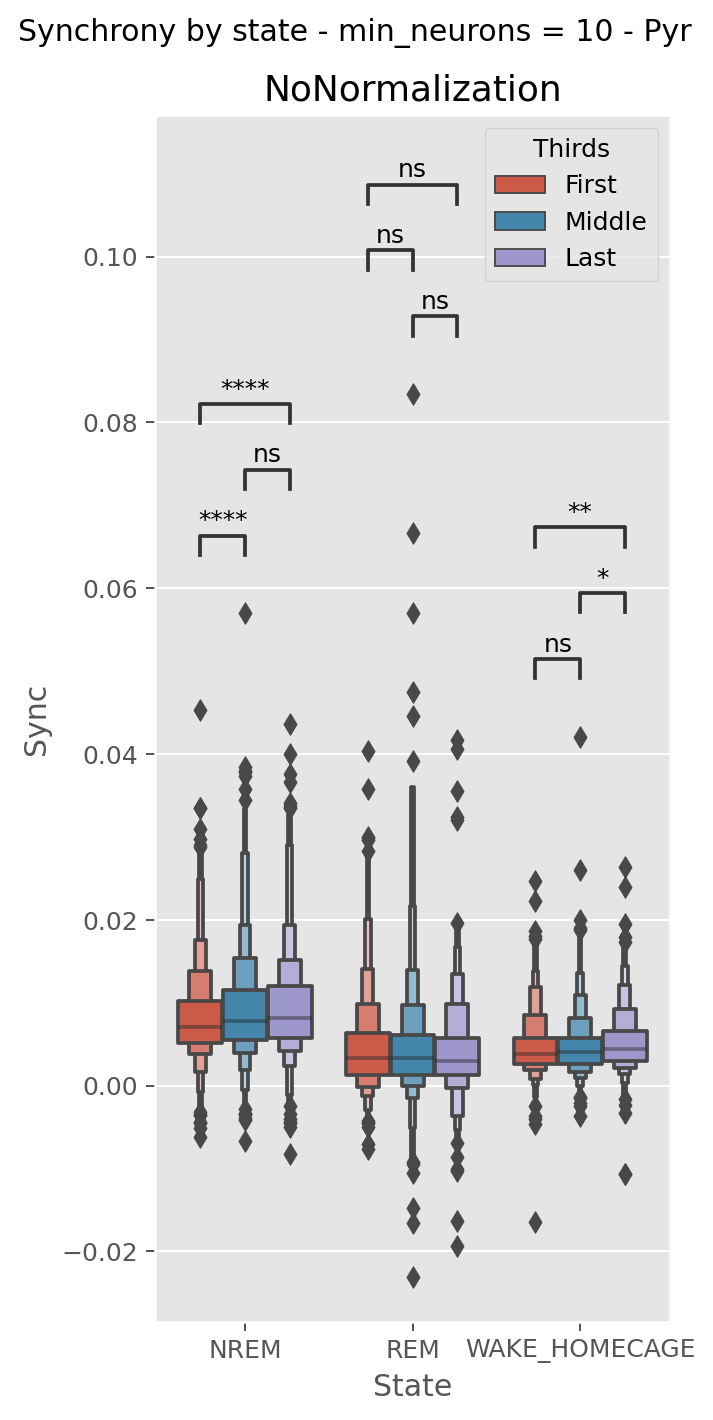

In [167]:
all_sync = all_sync.melt(id_vars=['Rat','Day','State'],var_name='Thirds',value_name='Sync',value_vars=['First','Middle','Last'])
fig,ax = plt.subplots(1,1,figsize=(4,8),dpi = 180)
plotting_params = {'data': all_sync,
                   'y': 'Sync',
                   'x':'State',
                   'dodge':True,
                   'hue':'Thirds',
                   'order':['NREM','REM','WAKE_HOMECAGE'],
                   'ax':ax}
sns.boxenplot(**plotting_params)
annotator = Annotator(pairs = pairs,**plotting_params)
annotator.configure(test="Wilcoxon",comparisons_correction = 'Bonferroni').apply_and_annotate()
ax.set_title('NoNormalization')
plt.suptitle(f'Synchrony by state - min_neurons = 10 - Pyr')
plt.tight_layout()
plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures/Ongoing/synchrony/Parts/sync_state_thirds_10neurons_100ms.svg')

ValueError: Could not interpret input 'Sync'

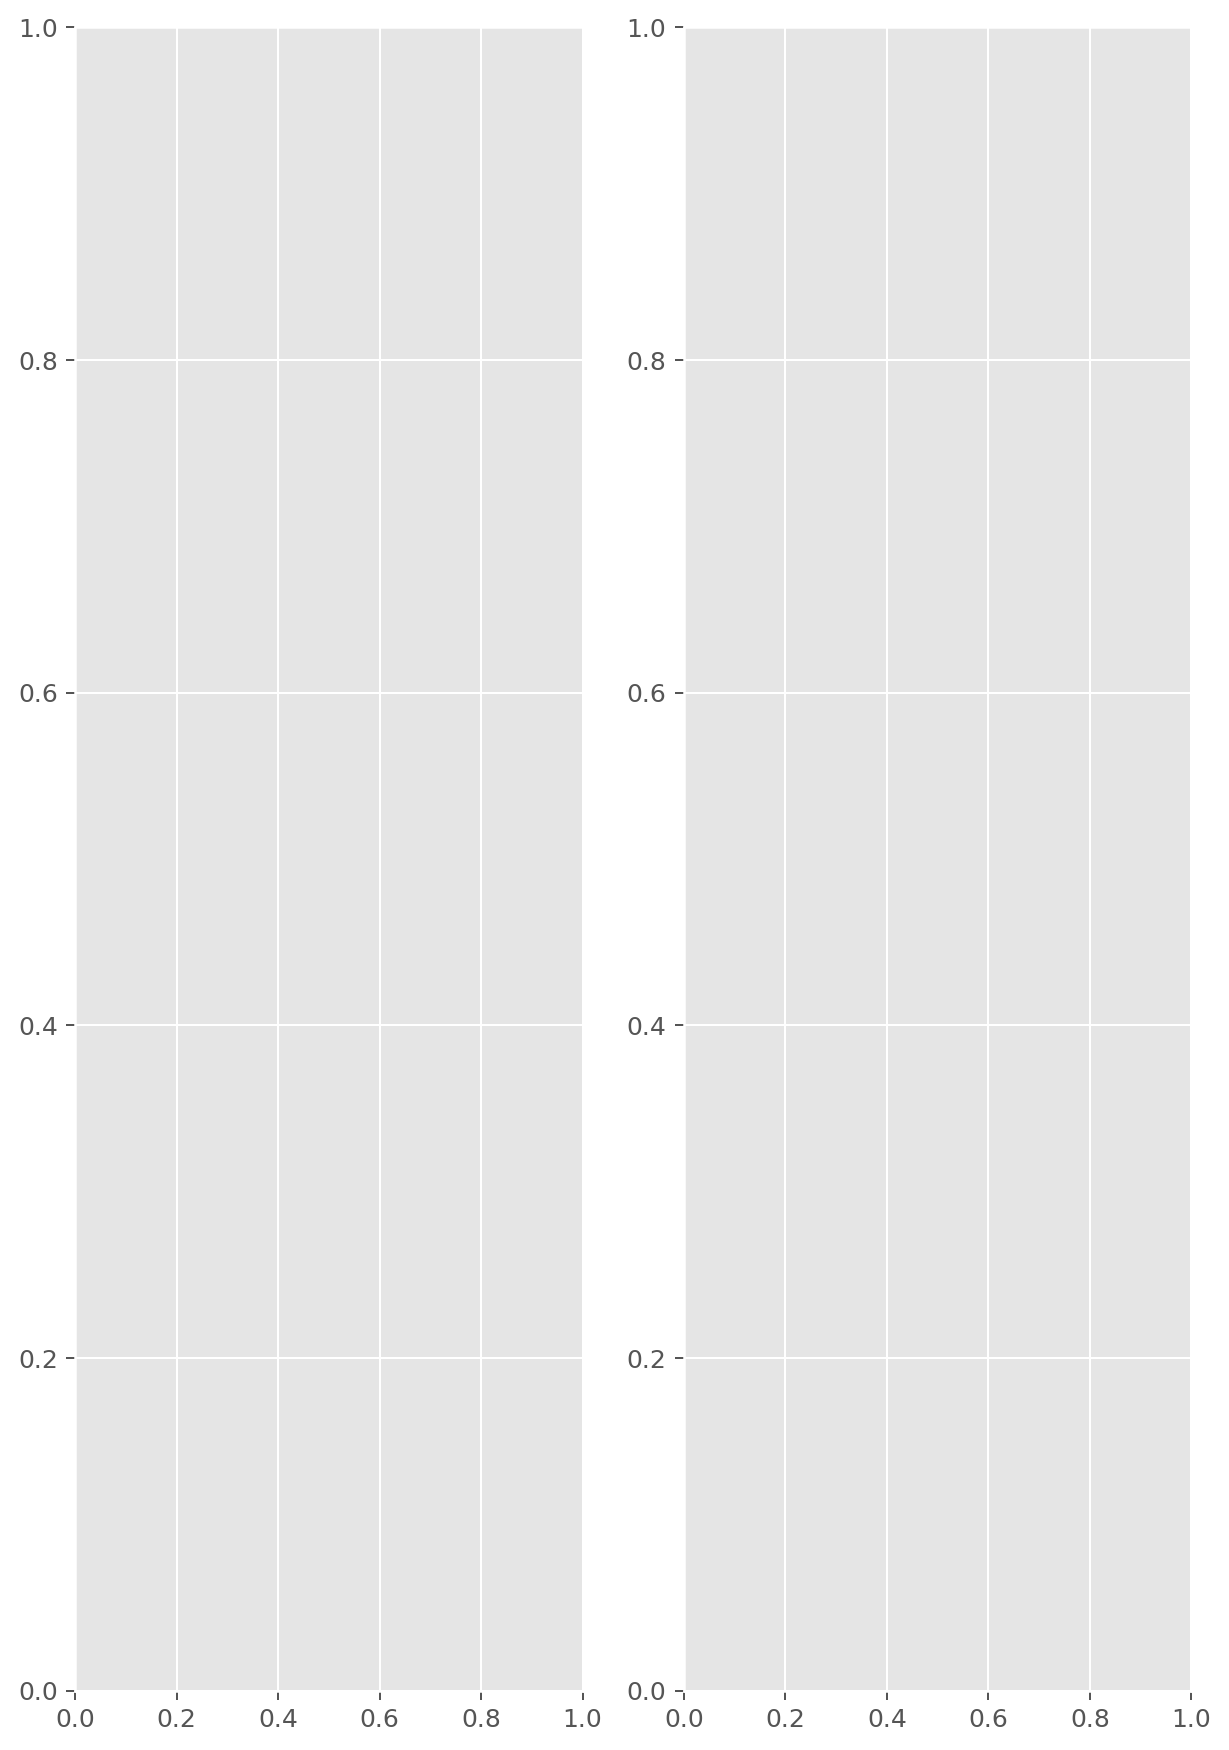

In [294]:
fig,ax = plt.subplots(1,2,figsize=(8,12),dpi = 180)
sns.boxplot(data = all_sync,y = 'Sync',x = 'State',hue='Thirds',ax = ax[0],dodge=True,showmeans = True,meanprops={"marker":".",
                                                                                                                  "markerfacecolor":"white"})
ax[0].set_title('NoNormalization')

#Normalize the data to 100% of first third of epoch : 
sns.boxplot(data = all_sync,y = 'Sync',x = 'State',hue='Thirds',ax = ax[1],dodge=True,showmeans = True,meanprops={"marker":".",
                                                                                                                  "markerfacecolor":"white"})
ax[1].set_title('Pourcent of First')
plt.ylim(-500,500)
plt.suptitle(f'Synchrony by state - min_neurons = 10 - Pyr')
plt.tight_layout()

In [55]:
all_sync = pd.concat(batch_thirds)
all_sync
values_states = {}
for state in np.unique(all_sync.State): 
    values_states[state]= {}
    for third in ['First','Middle','Last']:values_states[state][third] = all_sync[all_sync.State == state][third].values

for state in np.unique(all_sync_norm.State):
    print(f'{state}')
    print(multi_wilcoxon(values_states[state],9))
    print('\n')

NameError: name 'batch_thirds' is not defined

In [7]:
from imports import *

In [8]:
def compute_sync_moving_window(neurons, metadata, stru, types, start=0, stop=None, binSize=0.025, window_size=10, step=1):

    """
    This function compute sync value between two time point for a structure of interest
    """
    #Check what type of neurons we are working with and bin the spikes only of those.
    if types == 'Pyr':
        activity = bk.compute.binSpikes(neurons[(metadata.Region == stru) & (metadata.Type == 'Pyr')], start=start, stop=stop, binSize=binSize, as_Tsd=True)
    if types == 'Int':
        activity = bk.compute.binSpikes(neurons[(metadata.Region == stru) & (metadata.Type == 'Int')], start=start, stop=stop, binSize=binSize, as_Tsd=True)
    if types == 'both':
        activity = bk.compute.binSpikes(neurons[(metadata.Region == stru)], start=start, stop=stop, binSize=binSize, as_Tsd=True)

    #Compute the corr matrix and then compute the synchrony as the average of the pairwise correlation matrix of the binspikes matrices

    bins = np.arange(start,activity.times('s')[-1],step)
    sync = []
    t = []
    for s,e in tqdm(zip(bins,bins+window_size),total = len(bins)):
        if e>activity.times('s')[-1]: continue 
        sync_ = compute_sync(neurons,metadata,start = s,stop = e,binSize = binSize,stru = stru,types = types)
        sync.append(sync_)
        t.append((s+e)/2)
    sync = nts.Tsd(np.array(t),np.array(sync),time_units='s')
    return sync


def sync_intervals_moving_window(neurons, metadata, stru, types, intervals, binSize,window_size,step):
    """
    This function computes synchrony values for a given list of intervals.

    Arguments:
    neurons -- List of neurons (Ts)
    metadata -- DataFrame containing information on the neurons
    stru -- The structures of interest ('BLA','Hpc')
    types -- Types of neuron to be considered ('Pyr','Int','Both')
    intervals -- nts.IntervalSet
    binSize -- Size of the bin used for the computation of the corrmatrix
    """
    if len(intervals) == 0:
        sync = np.nan
        return sync

    # iterate over all epochs of one state
    intervals_sync_matrix = []
    for s, e in tqdm(intervals.as_units('s').iloc(), total=len(intervals)):
        # inter = nts.IntervalSet(s,e,time_units='s')
        # Compute one value of sync by epochs and add it to a list.
        sync_ = compute_sync_moving_window(neurons, metadata, start=s,
                             stop=e, binSize=binSize, stru=stru, types=types,window_size = window_size,step = step)
        intervals_sync_matrix.append(sync_)
    return intervals_sync_matrix

In [7]:
def main(base_folder, local_path, *args, **kwargs):
    """
    This function computes synchrony values for states REM/NREM/WAKE_HOMECAGE
    
    Arguments:
    base_folder -- Folder with the data
    local_path -- Local path to the session to be treated

    **kwargs -- A dict of other parameters, namely : 
        - stru: The structures of interest ('BLA','Hpc')
        - types: Types of neuron to be considered ('Pyr','Int','Both')
        - binSize: The size of the binning matrix
        - minimal_duration_epoch: The minimal length of a epoch to be considered in this analyis. Other epoch are discared
        - min_neurons: Minimal number of pyramidal neurons to be considered 
        - time_from_border: Can remove edges of each epochs in case of blurry transitions. 
    ...
    
    Returns:
    df -- A DataFrame with a line by epoch. It contains the average synchrony of this epoch and the state of the epoch
    ...
    """

    stru = kwargs['stru']
    types = kwargs['types']
    binSize = kwargs['binSize']
    min_neurons = kwargs['min_neurons']
    window_size = kwargs['window_size']
    step = kwargs['step']

    #Load session
    bk.load.current_session_linux(base_folder=base_folder, local_path=local_path)
    neurons, metadata = bk.load.spikes()
    states = bk.load.states(True)

    # if not enough neurons raise an exception
    if len(neurons[(metadata.Region == stru)& (metadata.Type == 'Pyr')])<min_neurons:
        raise Exception('Not Enough Neurons')

    sync = compute_sync_moving_window(neurons, metadata, stru, types, 0,None,binSize,window_size,step)

    return sync


kwargs = {'stru': 'BLA',
          'types': 'Pyr',
          'binSize': 0.1,
          'min_neurons':11,
          'window_size':10,
          'step':1
          }
bk.load.current_session_linux()
sync = main(bk.load.base,'Rat08/Rat08-20130713',**kwargs)
# batch, metadata = bk.load.batch(main, **kwargs)


Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713
Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713
Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy


100%|██████████| 22680/22680 [07:36<00:00, 49.69it/s]


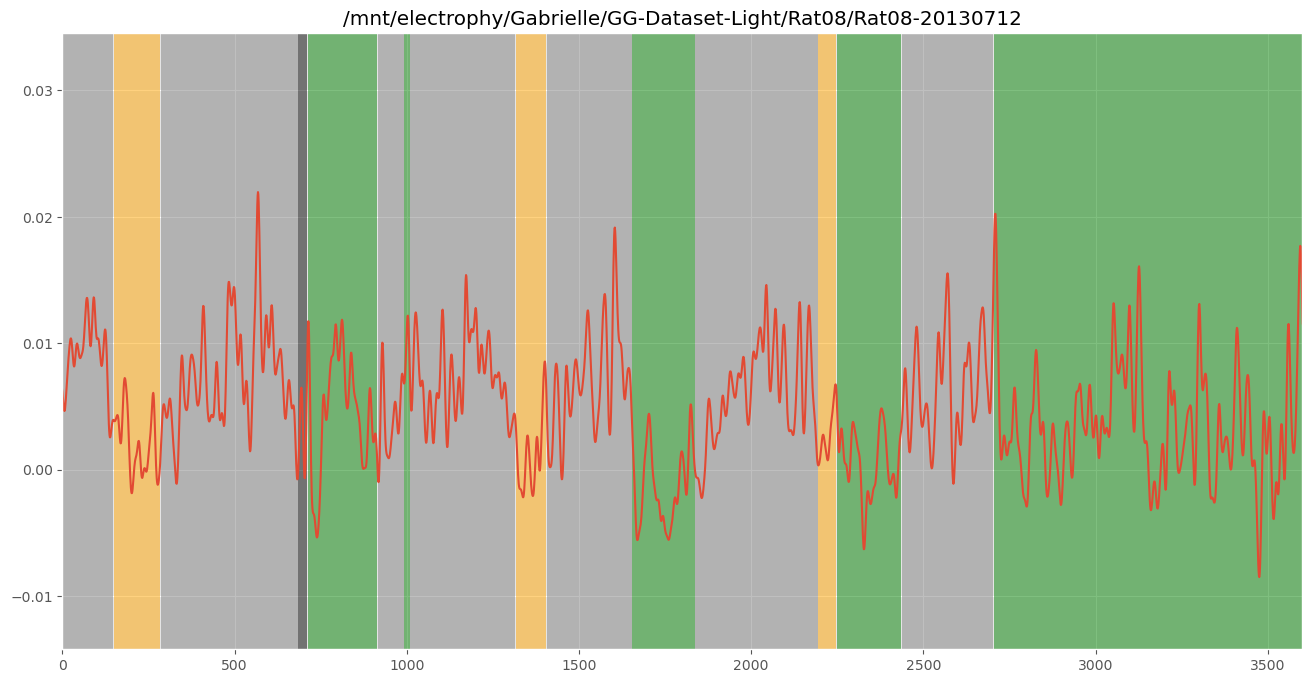

In [306]:
# sync = main(bk.load.base,'Rat08/Rat08-20130712',**kwargs)
states = bk.load.states(True)
states_labels = ['NREM','REM','WAKE_HOMECAGE','drowsy']
colors = ['grey','orange','green','black']

fig,ax = plt.subplots(figsize = (16,8))
# plt.plot(sync.times('s')-5100,sync.values)
plt.plot(sync.times('s')-5100,bk.compute.nts_smooth(sync,1000,4).values)
plt.xlim(0,3600)

for s,c in zip(states_labels,colors):
    bk.plot.intervals(states[s]-5100*1_000_000,col = c,ax = ax)

plt.title(f'{bk.load.path}')
plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures/Ongoing/synchrony/Parts/example.svg')

In [9]:
def main(base_folder, local_path, *args, **kwargs):
    """
    This function computes synchrony values for states REM/NREM/WAKE_HOMECAGE

    Arguments:
    base_folder -- Folder with the data
    local_path -- Local path to the session to be treated

    **kwargs -- A dict of other parameters, namely : 
        - stru: The structures of interest ('BLA','Hpc')
        - types: Types of neuron to be considered ('Pyr','Int','Both')
        - binSize: The size of the binning matrix
        - minimal_duration_epoch: The minimal length of a epoch to be considered in this analyis. Other epoch are discared
        - min_neurons: Minimal number of pyramidal neurons to be considered 
        - time_from_border: Can remove edges of each epochs in case of blurry transitions. 
    ...

    Returns:
    df -- A DataFrame with a line by epoch. It contains the average synchrony of this epoch and the state of the epoch
    ...
    """

    stru = kwargs['stru']
    types = kwargs['types']
    binSize = kwargs['binSize']
    min_duration_epoch = kwargs['min_duration']
    min_neurons = kwargs['min_neurons']
    time_from_border = kwargs['time_from_border']
    window_size = kwargs['window_size']
    step = kwargs['step']

    # Load session
    bk.load.current_session_linux(
        base_folder=base_folder, local_path=local_path)
    neurons, metadata = bk.load.spikes()
    states = bk.load.states(True)

    # Remove wake and drowsy intervals as they are not intereting here
    for s in ['wake', 'drowsy']:
        states.pop(s)

    # if not enough neurons raise an exception
    if len(neurons[(metadata.Region == stru) & (metadata.Type == 'Pyr')]) < min_neurons:
        raise Exception('Not Enough Neurons')

    sync = {}
    df = pd.DataFrame()
    # For each state left in states.items compute a value of sync per epoch
    for k, state in states.items():
        # We remove what is close to transition as the sleep scoring might not be perfect
        discard_border(state, time_from_border[k])
        state = state.drop_short_intervals(
            min_duration_epoch[k], 's').reset_index(drop=True)
        sync[k] = sync_intervals_moving_window(
            neurons, metadata, stru, types, state, binSize,window_size,step)
    
    return sync


kwargs = {'stru': 'BLA',
          'types': 'Pyr',
          'binSize': 0.1,
          'min_duration':
          {
              'REM': 30,
              'NREM': 200,
              'WAKE_HOMECAGE': 200
          },
          'min_neurons': 11,
          'time_from_border':
          {'REM': 5,
           'NREM': 20,
           'WAKE_HOMECAGE': 20
           },
          'window_size': 10,
          'step': 1
          }
bk.load.current_session_linux()
# sync = main(bk.load.base,'Rat08/Rat08-20130713',**kwargs)
# batch, metadata = bk.load.batch(main, **kwargs)

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713


True

In [169]:
def merge(batch):
    sync = {}
    for state in ['NREM','REM','WAKE_HOMECAGE']: sync[state] = []
    for sess,b in batch.items():
        for state in b:
            sync[state].append(b[state])
    return sync

In [260]:
# sync = np.save('/mnt/electrophy/Gabrielle/GG-Dataset-Light/All-Rats/Synchrony/sync_dynamics_states_cropped_epochs.npy',sync,allow_pickle=True)

In [253]:
sync = merge(batch)

In [20]:
sync = np.load('/mnt/electrophy/Gabrielle/GG-Dataset-Light/All-Rats/Synchrony/sync_dynamics_states_cropped_epochs.npy',allow_pickle=True).flatten()[0]

In [21]:
sync_flat = {}
for state in ['NREM','REM','WAKE_HOMECAGE']:
    sync_flat[state] = []
    for sublist in sync[state]:
        for item in sublist:
            sync_flat[state].append(item)

In [31]:
def average_by_bin(t,data,nbins):
    bins = np.linspace(t[0],t[-1],nbins+1)
    digitized = np.digitize(t,bins)
    bin_means = [np.nanmean(data[digitized==i]) for i in range(1,len(bins))]

    return bin_means

In [41]:
nbins = {'REM': 12, 'NREM': 30, 'WAKE_HOMECAGE': 30}

regress = {'slope': [],
           'intercept': [],
           'rvalue': []}
labels = []
dynamics = []

all_dynamics = {}


for state in ['NREM', 'WAKE_HOMECAGE', 'REM']:
    all_dynamics[state] = np.array([[],[]])
    for s in sync_flat[state]:
        t = s.times('s')-s.times('s')[0]
        t = np.round(t,0)
        v = s.values

        reg = scipy.stats.linregress(t, v)


        regress['slope'].append(reg.slope)
        regress['intercept'].append(reg.intercept)
        regress['rvalue'].append(reg.rvalue)

        labels.append(state)
        
        averaged_by_bin = average_by_bin(t, v, nbins[state])
        dynamics.append(averaged_by_bin)

        # all_dynamics[state] = np.hstack((all_dynamics[state],np.array([t,v])))
        all_dynamics[state] = np.hstack((all_dynamics[state],np.array([range(len(averaged_by_bin)),averaged_by_bin])))
        
        





r = np.array(regress['rvalue'])
labels = np.array(labels)
dynamics = np.array(dynamics)
data = np.vstack((r, labels))
df = pd.DataFrame(zip(dynamics, regress['slope'], regress['intercept'], regress['rvalue'], labels), columns=[
                  'Dynamics', 'Slope', 'Intercept', 'r-value', 'State'])

/tmp/ipykernel_221361/2668956569.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dynamics = np.array(dynamics)


In [42]:
all_dynamics['NREM'][0]

array([ 0.,  1.,  2., ..., 27., 28., 29.])

LinregressResult(slope=6.626002722487546e-05, intercept=0.009332189964977351, rvalue=0.06097648897570514, pvalue=3.855865697423274e-11, stderr=1.0015400723000685e-05, intercept_stderr=0.00016912885549187322)
LinregressResult(slope=-2.7609221137492317e-05, intercept=0.005517360545535452, rvalue=-0.009738901815669812, pvalue=0.5558638569125007, stderr=4.6870730332210415e-05, intercept_stderr=0.0003043591454609509)
LinregressResult(slope=8.724305937138902e-06, intercept=0.0054697135690556535, rvalue=0.009984974750468717, pvalue=0.35592341755672896, stderr=9.449960829504288e-06, intercept_stderr=0.00015958034069137505)


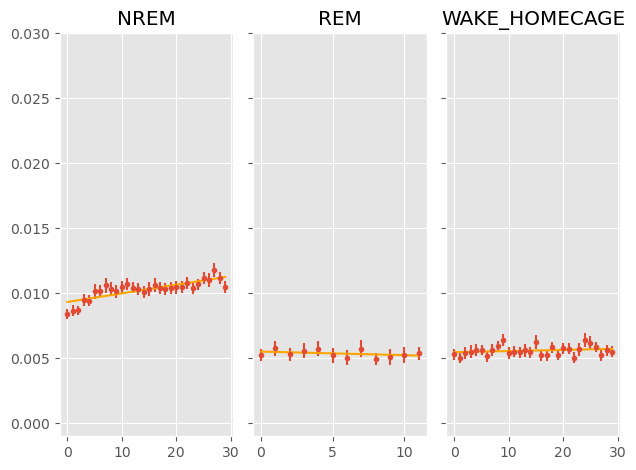

In [44]:
fig,ax = plt.subplots(1,3,sharey=True)
for i,state in enumerate(['NREM', 'REM', 'WAKE_HOMECAGE']):
    x = range(int(np.max(all_dynamics[state][0,:]))+1)   
   
    means = [np.mean(all_dynamics[state][1,:][np.where(all_dynamics[state][0,:] == i)])for i in x]
    std = [scipy.stats.sem(all_dynamics[state][1,:][np.where(all_dynamics[state][0,:] == i)])for i in x]
    
    reg = scipy.stats.linregress(all_dynamics[state])
    y = (reg.slope * x) + reg.intercept
    print(reg)

    # ax[i].scatter(all_dynamics[state][0,:],all_dynamics[state][1,:],alpha=0.5,s = 1)
    ax[i].errorbar(x,means,std,linestyle='None', marker='.')
    ax[i].plot(x,y,color = 'orange')
    ax[i].set_ylim(-0.001,0.03)
    ax[i].set_title(state)
plt.tight_layout()

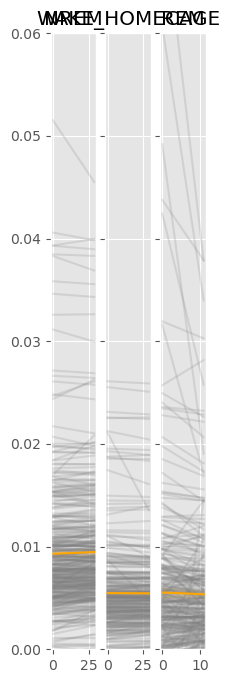

In [22]:
fig,ax = plt.subplots(1,3,figsize = (2,8),sharey=True)
for k,state in enumerate(df.State.unique()):
    df_state = df[df.State == state]
    nbins = (len(df_state.Dynamics.values[0]))
    x = (range(nbins))
    y = []
    for i in df_state.iloc:
        # y.append(i.Dynamics)
        y.append((i.Slope * x) + i.Intercept)
    ax[k].plot(np.array(y).T,color = 'grey',alpha = 0.2)
    bk.plot.curve_and_shades(x,y,ax = ax[k],method='sem')
    ax[k].set_title(state)
    ax[k].set_ylim(0,0.06)

In [227]:
print('NREM',scipy.stats.shapiro(df.rvalue[df.State == 'NREM']))
print('REM',scipy.stats.shapiro(df.rvalue[df.State == 'REM']))
print('WAKE_HOMECAGE',scipy.stats.shapiro(df.rvalue[df.State == 'WAKE_HOMECAGE']))

AttributeError: 'DataFrame' object has no attribute 'rvalue'

In [228]:
def plot_dynamics_state(df,state,ax):
    data = np.vstack(df['Dynamics'][df.State == state])
    print(data.shape)
    bk.plot.confidence_intervals(range(data.shape[1]),data,ax=ax)

(391, 30)
(305, 12)
(285, 30)


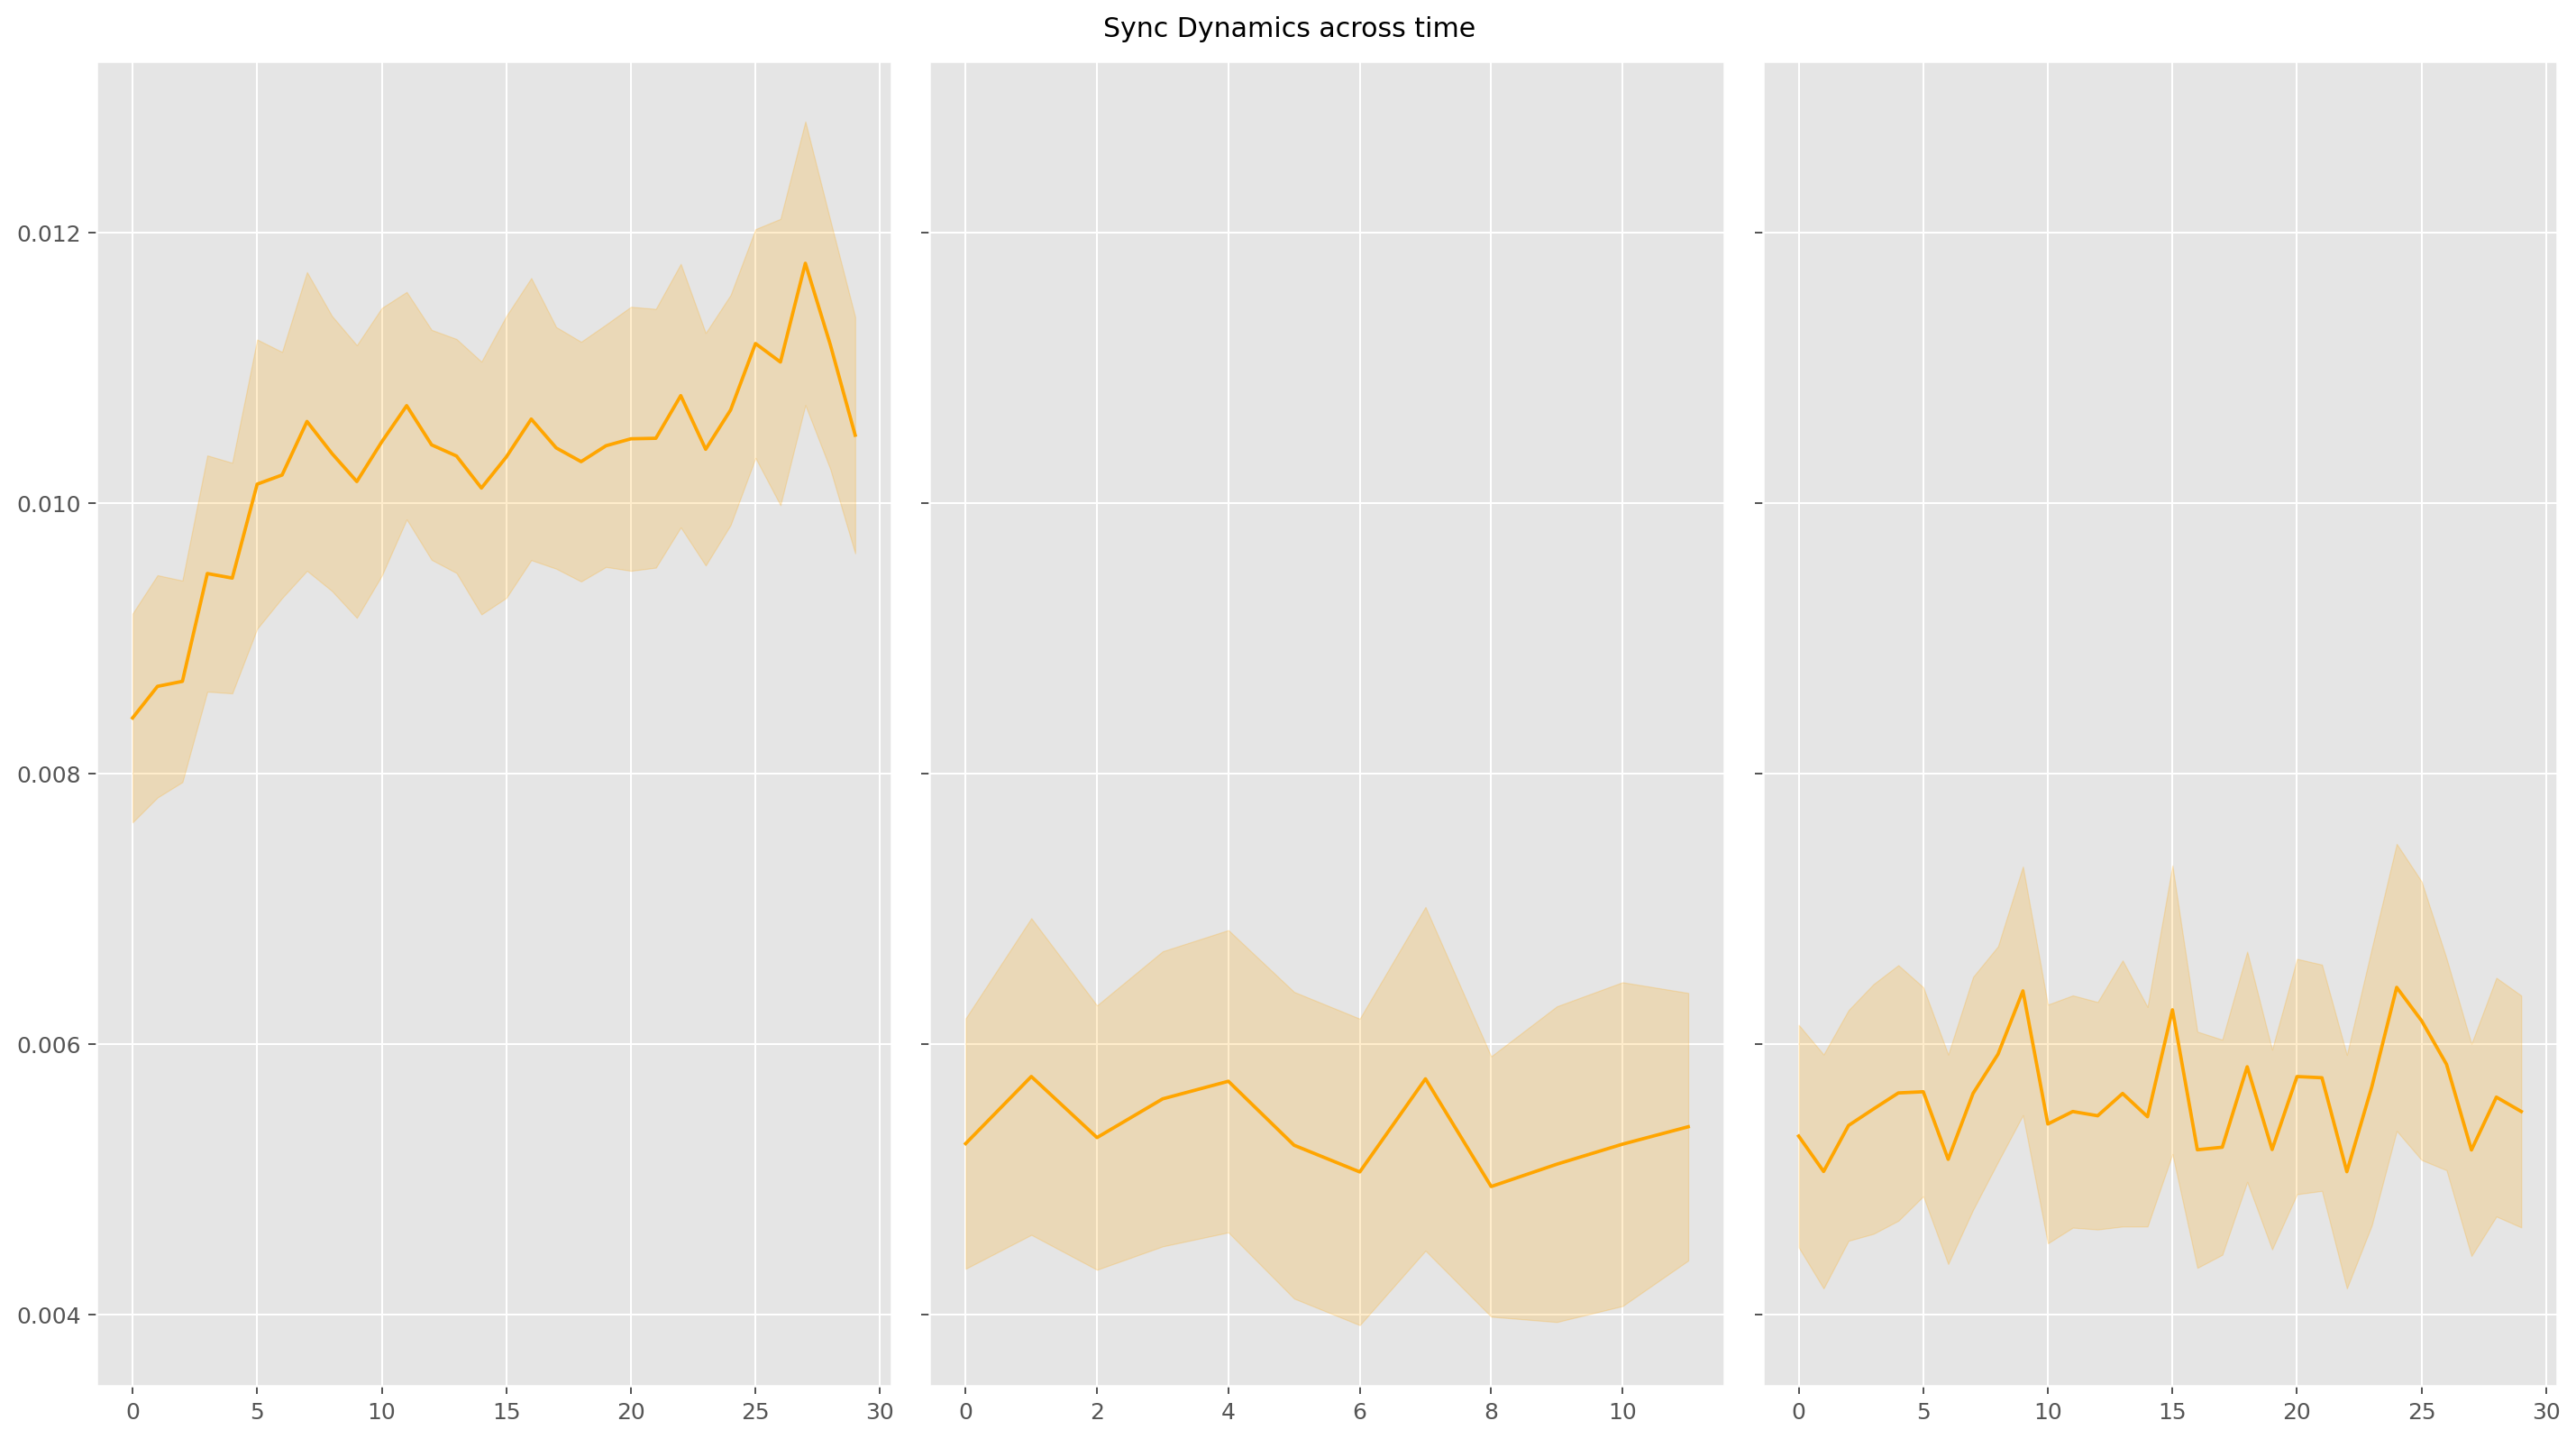

In [229]:
fig,ax = plt.subplots(1,3,sharey=True,dpi = 180,figsize = (16,9))
for i, state in enumerate(['NREM','REM','WAKE_HOMECAGE']):
    plot_dynamics_state(df,state,ax[i])
plt.suptitle('Sync Dynamics across time')
plt.tight_layout()


In [236]:
pvalues = {}
for state in df['State'].unique():
    print(state)
    print(scipy.stats.ttest_1samp(df['r-value'][df.State == state],0))
    pvalues[state] = bk.stats.formatting_pvalues(np.array(scipy.stats.ttest_1samp(df['r-value'][df.State == state],0).pvalue))

NREM
Ttest_1sampResult(statistic=8.532161329346552, pvalue=3.2234559551358686e-16)
WAKE_HOMECAGE
Ttest_1sampResult(statistic=1.9231797407731606, pvalue=0.055457176125933476)
REM
Ttest_1sampResult(statistic=-0.22969414020666226, pvalue=0.8184839180715408)


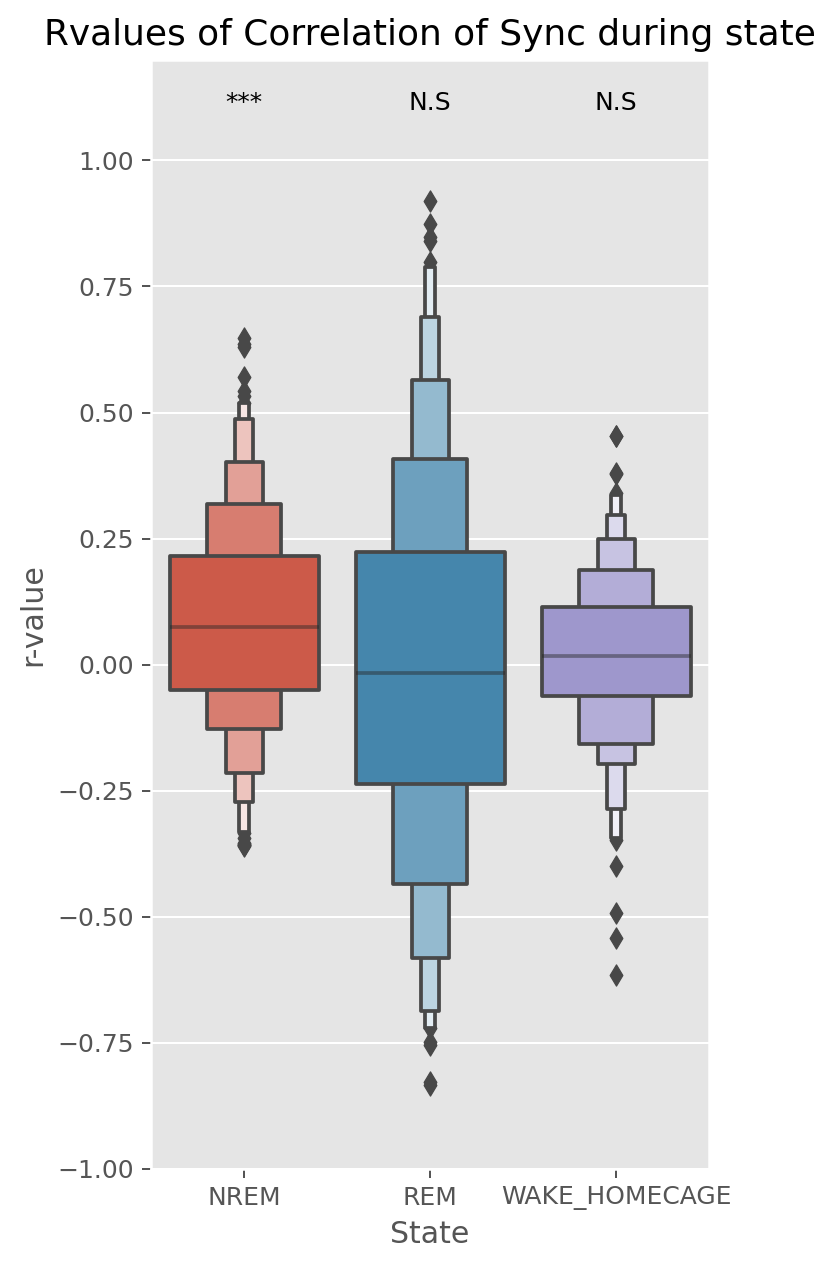

In [237]:
plt.figure(figsize = (4,8),dpi = 180)
sns.boxenplot(data = df,x = 'State',y = 'r-value',order = ['NREM','REM','WAKE_HOMECAGE'])
plt.ylim(-1,1.2)
plt.title('Rvalues of Correlation of Sync during state')

for i,state in enumerate(df['State'].unique()): plt.text(i,1.1,pvalues[state],horizontalalignment = 'center')
plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures/Ongoing/synchrony/Parts/ravlues.svg')


In [32]:
for state in ['NREM','REM','WAKE_HOMECAGE']:
    print(state,scipy.stats.wilcoxon(df['rvalues'][df.State == state]))

NREM WilcoxonResult(statistic=24069.0, pvalue=6.032824713135442e-17)
REM WilcoxonResult(statistic=28842.0, pvalue=0.8633708435800067)
WAKE_HOMECAGE WilcoxonResult(statistic=18862.0, pvalue=0.006344334346632344)


# Compare First And Last NREM / REM of Extended sleep. 

In [178]:
def main(base_folder, local_path, *args, **kwargs):
    """
    This function computes synchrony values for the first and last of extended sleep
    Arguments:
    base_folder -- Folder with the data
    local_path -- Local path to the session to be treated

    **kwargs -- A dict of other parameters, namely : 
        - stru: The structures of interest ('BLA','Hpc')
        - types: Types of neuron to be considered ('Pyr','Int','Both')
        - binSize: The size of the binning matrix
        - min_neurons: Minimal number of pyramidal neurons to be considered 
    ...

    Returns:
    df -- A DataFrame with a line by epoch. It contains the average synchrony of this epoch and the state of the epoch
    ...
    """

    stru = kwargs['stru']
    types = kwargs['types']
    binSize = kwargs['binSize']
    min_neurons = kwargs['min_neurons']

    # Load session
    bk.load.current_session_linux(
        base_folder=base_folder, local_path=local_path)
    neurons, metadata = bk.load.spikes()
    if len(neurons[(metadata.Region == stru) & (metadata.Type == 'Pyr')]) < min_neurons:
        raise Exception('Not Enough Neurons')

    states = bk.load.states(True)
    extended_sleep = bk.compute.extended(states, 'sleep', 60*30, 60)
    df = pd.DataFrame()
    for state in ['NREM', 'REM']:
        for s, e in extended_sleep.iloc:
            current_sleep = nts.IntervalSet(s, e)
            first = states[state].intersect(current_sleep)[0:1]
            last = states[state].intersect(current_sleep)[-1:]

            first = {'start': first.as_units('s').start.values,
                     'end': first.as_units('s').end.values}
            last = {'start': last.as_units('s').start.values,
                     'end': last.as_units('s').end.values}

            first_sync = compute_sync(neurons, metadata, stru, types, first['start'],first['end'] , binSize)
            last_sync = compute_sync(neurons, metadata, stru, types, last['start'],last['end'], binSize)

            df_ = pd.DataFrame([[first_sync, last_sync, state]], columns=[
                               'First', 'Last', 'State'])
            df = pd.concat((df, df_))
    return df


kwargs = {'stru': 'BLA',
          'types': 'Pyr',
          'binSize': 0.1,
          'min_neurons': 11
          }

bk.load.current_session_linux()
# sync = main(bk.load.base, 'Rat08/Rat08-20130713', **kwargs)
batch, metadata = bk.load.batch(main, **kwargs)


100%|██████████| 61/61 [02:16<00:00,  2.24s/it]

Batch finished in 136.47959542274475
Some session were not processed correctly
['Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140704', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
45.90163934426229 %


In [201]:
df = pd.concat(batch)
df_melt = df.melt(id_vars='State',var_name='epoch',value_vars=['First','Last'],value_name='Sync')

In [205]:
df_melt['Sync']

0      0.028202
1      0.026336
2      0.007965
3      0.008170
4      0.005778
         ...   
103    0.001193
104    0.015404
105    0.014479
106    0.003504
107    0.007558
Name: Sync, Length: 108, dtype: float64

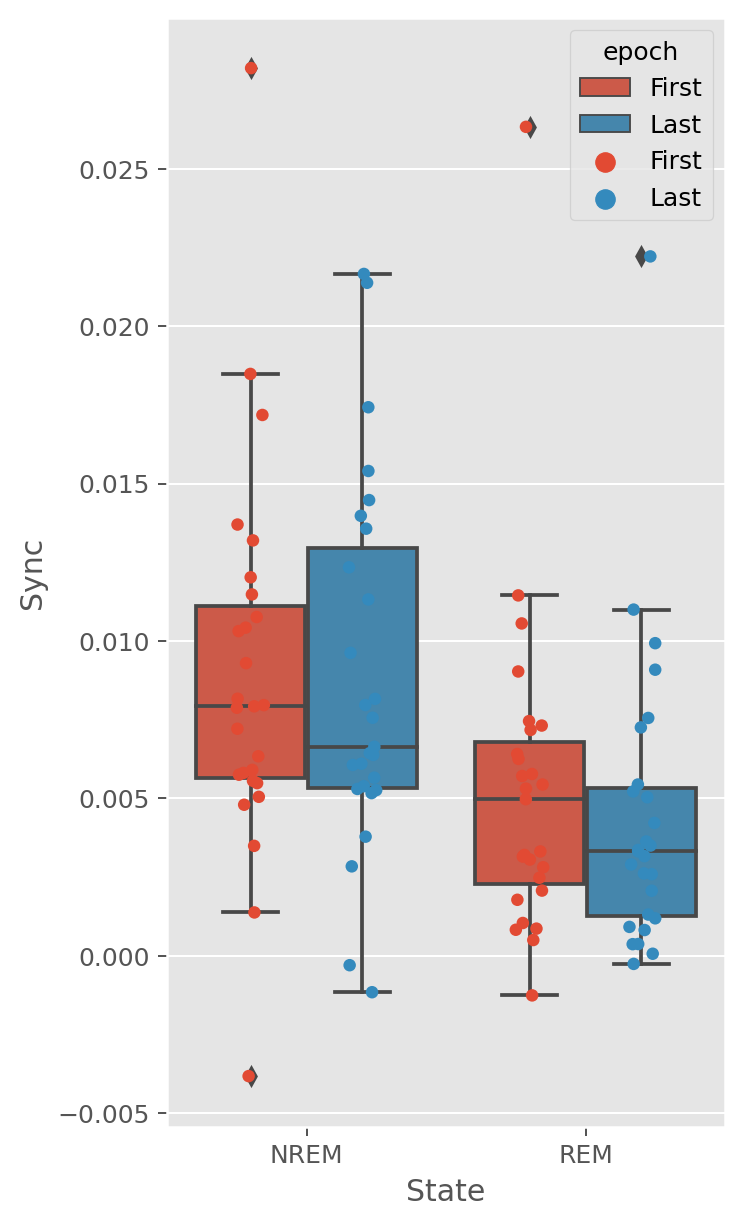

In [220]:
# df = pd.concat(batch)
plt.figure(figsize=(4,8),dpi = 180)
sns.boxplot(data = df_melt,x = 'State',y = 'Sync',hue = 'epoch',dodge=True)
sns.stripplot(data = df_melt,x = 'State',y = 'Sync',hue = 'epoch',dodge=True)
plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures/Ongoing/synchrony/Parts/sync_extended_sleep.svg')

In [219]:
0.11242805967934756*2

0.22485611935869512

In [211]:
for state in ['NREM','REM']:
    print(len(df['First'][df.State == state]))
    print(state,scipy.stats.wilcoxon(df['First'][df.State == state],df['Last'][df.State == state]))

27
NREM WilcoxonResult(statistic=187.0, pvalue=0.9616763959455763)
27
REM WilcoxonResult(statistic=113.0, pvalue=0.11242805967934756)
